!pip3 install ipywidgets

# Fútbol bayesiano

Carga de librerías

In [1]:
import os
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cmdstanpy import CmdStanModel

Se definen rutas relativas del archivo

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [3]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

# 1. Análisis exploratorio de datos

## 1.1 Exploración tabular

Dimensiones básicas del conjunto de datos

In [4]:
# Lectura de datos en bruto
futbol_df = pd.read_csv(
    os.path.join(ROOT, config['datos']['raw'])
    ,encoding='latin-1'
)

# Generar catálogo de datos
info_ = os.path.join(ROOT, config['datos']['cat_raw'])

with open(file=info_, mode='w') as file_:
    futbol_df.info(buf=file_)
file_.close()

print(' Dims. Básicas '.center(35, '-'))
print('rows:'.ljust(10, ' ') + f'{futbol_df.shape[0]:_.0f}')
print('cols:'.ljust(10, ' ') + f'{futbol_df.shape[1]:_.0f}')

---------- Dims. Básicas ----------
rows:     23_921
cols:     44


Formatear los nombres de las columnas a *snake_case*

In [5]:
futbol_df.columns = [col_name.lower() for col_name in futbol_df.columns]

Se seleccionan únicamente los partidos registrados después del mundial del 2018 en adelante, esto es debido a que se utilizará este como periodo de entrenamiento para los modelos, para posteriormente hacer predicciones para el mundial de Qatar 2022

In [6]:
futbol_mask = (
    futbol_df
    .query('year > 2018')
    .filter(items=[
        'day'
        ,'month'
        ,'year'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'neutral_location'
        ,'home_team_score'
        ,'away_team_score'
        ,'home_team_fifa_rank'
        ,'away_team_fifa_rank'])
    .reset_index(drop=True)
)

print(' Dims. Básicas '.center(35, '-'))
print('rows:'.ljust(10, ' ') + f'{futbol_mask.shape[0]:_.0f}')
print('cols:'.ljust(10, ' ') + f'{futbol_mask.shape[1]:_.0f}')

---------- Dims. Básicas ----------
rows:     3_021
cols:     11


## 1.2 Completitud de los datos

Al hacer un mapa de calor de los valores faltantes, se observa que la base está completa después de hacer el filtrado de datos por fecha.

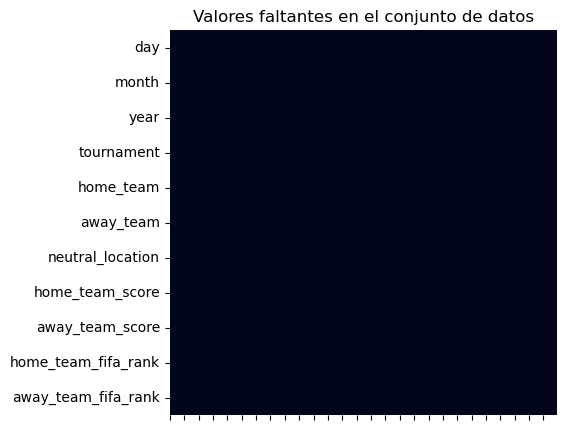

In [7]:
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(5,5))

# Elementos de figura
sns.heatmap(
    futbol_mask.isna().T
    ,cbar=False
    ,ax=ax)

# Anotaciones y estilo
ax.set_title('Valores faltantes en el conjunto de datos')
ax.set_xticklabels('')

plt.show()

## 1.2 Visualizaciones

Una primera visualización en la que se puede pensar es en el número de partidos que se jugaron en cada categoría de torneo

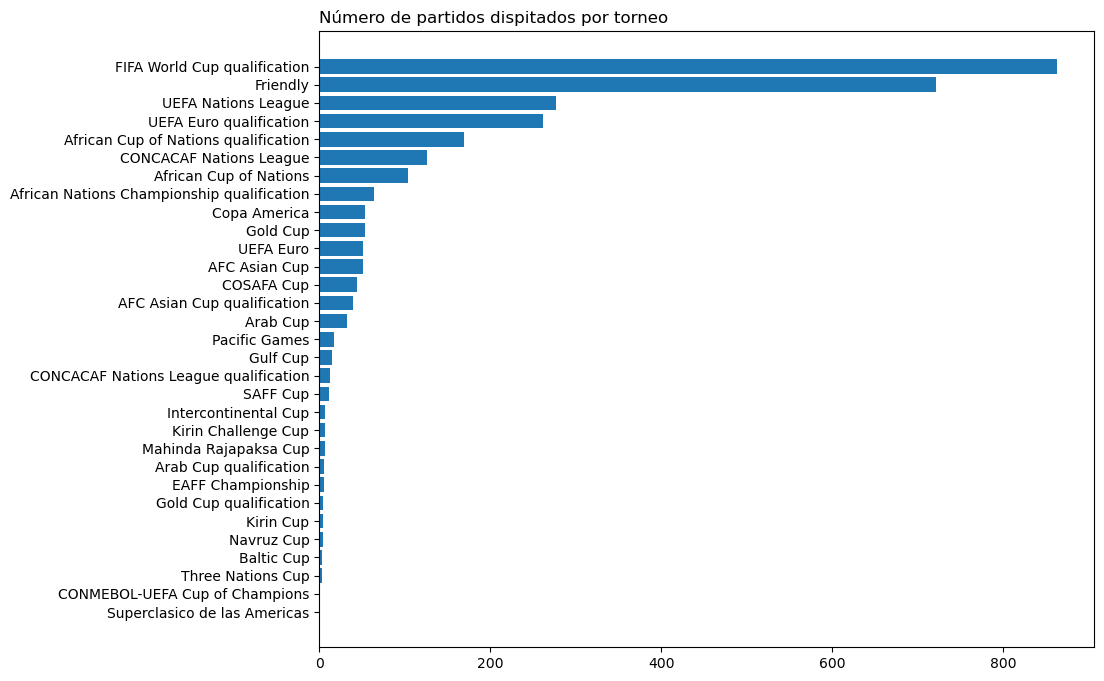

In [8]:
# Datos de la visualización
df_ = (
    futbol_mask
    .filter(items=['tournament', 'day'])
    .groupby(by='tournament')
    .count()
    .sort_values(by='day', ascending=True)
)
# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,8))

# Elementos de figura
ax.barh(
    y=df_.index
    ,width=df_.day
)
# Anotaciones y estilo
ax.set_title('Número de partidos dispitados por torneo', loc='left')

plt.show()

Otra visualización en la que se puede pensar es en la proporción de partidos que se disputaron en territorios neutrales. En una sección posterior, se modela la localía como un factor importante en la definición de un partido.

In [9]:
# Datos de visualización
(
    futbol_mask
    .filter(items=['neutral_location','day'])
    .groupby(by='neutral_location')
    .count()
    .assign(
        pct_partidos = lambda df_: df_.day / df_.day.sum()
    )
)

,day,pct_partidos
neutral_location,,
False,2197,0.727243
True,824,0.272757


Adicionalmente, se puede determinar el porcentaje de juegos en territorio neutral por torneo disputado.

In [10]:
(
    futbol_mask
    .filter(items=['tournament','neutral_location','day'])
    .pivot_table(
        values='day'
        ,index='tournament'
        ,columns='neutral_location'
        ,aggfunc='count')
    .fillna(value=0)
    .sort_values(by=True, ascending=False)
)

neutral_location,False,True
tournament,,
Friendly,495.0,226.0
FIFA World Cup qualification,716.0,147.0
African Cup of Nations,11.0,93.0
AFC Asian Cup,6.0,45.0
Copa America,13.0,41.0
Gold Cup,12.0,41.0
COSAFA Cup,9.0,35.0
African Cup of Nations qualification,139.0,30.0
Arab Cup,6.0,26.0


# 2. Modelado

## 2.1 Definición del modelo

`Describir aquí el planteamiento del problema`

## 2.2 Implementación

Primero se definen algunas rutas para la manipulación de archivos de `stan`

In [11]:
# Directorios a archivos de stan
INPUT_DIR = os.path.join(ROOT, config['modelos']['inputs'])
OUTPUT_DIR = os.path.join(ROOT, config['modelos']['outputs'])

# Rutas de modelos de stan
FILE_NAME = 'futbol_jerarquico.stan'
INPUT_ = os.path.join(INPUT_DIR, FILE_NAME)
OUTPUT_ = os.path.join(OUTPUT_DIR, FILE_NAME)


In [12]:
model_ = CmdStanModel(
    stan_file=INPUT_
    ,exe_file=OUTPUT_
    ,compile=True)